### Downloading the NVIDIA Stock Dataset with `kagglehub`

The snippet below shows how to fetch a specific version of the NVIDIA stock history from Kaggle using the `kagglehub` library:


In [19]:
import kagglehub

# Download selected version
path = kagglehub.dataset_download("adilshamim8/nvidia-stock-market-history/versions/1")

print("Path to dataset files:", path)

Path to dataset files: /Users/yungtingsoo/.cache/kagglehub/datasets/adilshamim8/nvidia-stock-market-history/versions/1


In [20]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob, os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import linear_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

### Locating and Selecting a CSV File

This snippet finds and validates the first CSV file in the downloaded dataset directory:


In [21]:
# Build a list of all CSV paths in the dataset folder
csv_paths = glob.glob(os.path.join(path, "*.csv"))
if not csv_paths:
    raise FileNotFoundError(f"No CSV files found in {path}")
csv_file = csv_paths[0]

### Loading the CSV into a Pandas DataFrame


In [22]:
df = pd.read_csv(csv_file, na_values=['null'], index_col='Date', parse_dates=True)
print(df.head())

               Close      High       Low      Open      Volume
Date                                                          
1999-01-22  0.037612  0.044775  0.035581  0.040119  2714688000
1999-01-25  0.041552  0.042029  0.037612  0.040597   510480000
1999-01-26  0.038328  0.042865  0.037731  0.042029   343200000
1999-01-27  0.038209  0.039403  0.036298  0.038447   244368000
1999-01-28  0.038089  0.038447  0.037850  0.038209   227520000


In [23]:
### Check for Any Missing Values in the DataFrame
df.isnull().values.any()

np.False_

In [24]:
### Inspecting the DataFrame’s Column Names
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

<Axes: title={'center': 'NVIDIA Close Price'}, xlabel='Date'>

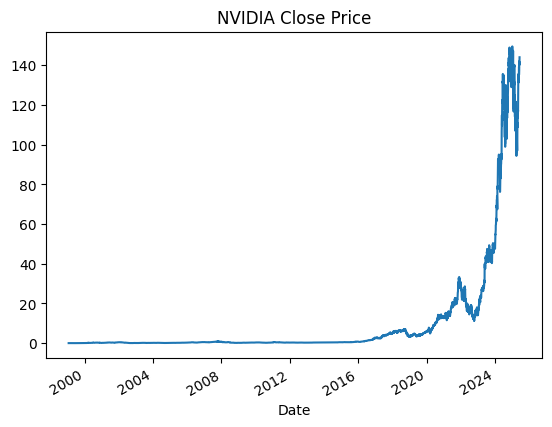

In [25]:
### Plotting the NVIDIA Closing Price Over Time

df['Close'].plot(title='NVIDIA Close Price')

In [26]:
### Defining the Target and Feature Sets

# Value of the stock at the end of the day to predict -- target variable
predict = pd.DataFrame(df['Close'])

# Features to use to predict the value of the stock -- input features
features = ['High', 'Low', 'Open', 'Volume']

### Normalizing Input Features with Min-Max Scaling
- **Why normalize?**
  - Neural networks (and many machine-learning algorithms) train more reliably and converge faster when all inputs share a similar scale. Here, we map each feature into the ```0,1``` range.

- **Steps explained**

  1. ```scaler = MinMaxScaler():```
     - Create a scaler that linearly transforms each feature so its minimum becomes 0 and its maximum becomes 1.
  2. ```scaler.fit_transform(df[features]):```
     - fit computes the min and max for each column in ```df[features]```.
     - transform applies the scaling to every value.
     - Returns a NumPy array of normalized values.
  4. ```pd.DataFrame(...):```
     - Wrap the scaled array back into a DataFrame, preserving the original column names and date index for easy alignment with our target series.
  5. ```features_normalised.head():```
     - Display the first few rows to confirm that each feature now lies between 0 and 1.

In [27]:
scaler = MinMaxScaler()
features_normalised = scaler.fit_transform(df[features])
features_normalised = pd.DataFrame(columns=features, data=features_normalised, index=df.index)
features_normalised.head()

,High,Low,Open,Volume
Date,,,,
1999-01-22,0.000080,0.000034,0.000053,0.292580
1999-01-25,0.000062,0.000048,0.000056,0.053283
1999-01-26,0.000067,0.000048,0.000066,0.035123
1999-01-27,0.000044,0.000039,0.000042,0.024393
1999-01-28,0.000038,0.000049,0.000041,0.022564


### Time-Series Cross-Validation with `TimeSeriesSplit`
- **What it does**
  - ```TimeSeriesSplit(n_splits=10)``` creates 10 sequential “folds” over your data, preserving the chronological order.
  - On each iteration, you get two index arrays:
    - ```training_index``` covers all observations from the start through a certain cutoff.
    - ```test_index``` covers the immediately subsequent block of observations.
- **Logic**
  1. Chronological split: unlike random k-fold, the test set always comes after the train set in time.
  2. Expanding window: each fold’s training set grows larger, so you simulate forecasting with more and more history.
     - Fold 1: train on first 10%, test on next 10%
     - Fold 2: train on first 20%, test on next 10%
     - ... up to Fold 10.
- **How slicing works**
  - ```features_normalised[:len(training_index)]``` takes the first N rows as the training features.
  - ```features_normalised[N : N + M]``` takes the next M rows as the test features.
  - Same logic for the target series predict, where .values.ravel() converts it to a 1-D NumPy array.

- **Why use this?**
  - It gives you a more robust estimate of how your model performs over different time periods and market regimes, without ever “peeking” into the future.
  - It’s especially important for financial time-series, where random shuffling would violate the temporal dependencies you’re trying to model.

In [28]:
timesplit = TimeSeriesSplit(n_splits=10)

for training_index, test_index in timesplit.split(features_normalised):
    X_train, X_test = features_normalised[:len(training_index)], features_normalised[len(training_index): (len(training_index)+len(test_index))]
    y_train, y_test = predict[:len(training_index)].values.ravel(), predict[len(training_index): (len(training_index)+len(test_index))].values.ravel()

### Preparing the Input Array for the LSTM
- **Why convert to NumPy?**
  - Keras models expect inputs as NumPy arrays (not DataFrames) for efficient numerical computation.
- **Why reshape to 3D?**
  - LSTM layers require input of shape (batch_size, timesteps, features).
    - ```batch_size``` is the number of samples (rows) you feed per training step.
    - ```timesteps``` is how many past time steps the model sees at once—in this case we use 1 (one day of features).
    - ```features``` is the number of input variables per time step (here len(features), e.g., 4).
- **Effect of this code:**
  - ```train_X.shape``` goes from ```(N_samples, N_features)``` → ```(N_samples, 1, N_features)```.
  - Now each training example is a 1‐day sequence with all feature values, ready for the LSTM’s ```(timesteps, features)``` input.
  - The same reshaping applies to the test set so it matches the model’s expected input shape.

In [29]:
# Convert the pandas DataFrames to plain NumPy arrays
train_X = np.array(X_train)
test_X  = np.array(X_test)

# Reshape into 3D tensors of shape (samples, timesteps, features)
X_train = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
X_test  = np.reshape(test_X,  (test_X.shape[0],  1, test_X.shape[1]))

### Scaling the Target Variable
- ```MinMaxScaler()```
  - Creates a scaler that will linearly transform values into the ```0,1``` range.
- ```y_train.reshape(-1, 1)```
  - Ensures ```y_train``` is a 2-dimensional array with shape ```(n_samples, 1)```, as required by scikit-learn scalers.
- ```scaler_y.fit_transform(y_train)```
  1. ```fit``` computes the minimum and maximum of the training targets.
  2. ```transform``` scales each value: <br> $y_{scaled} = \frac{y - y_{min}}{y_{max} - y_{min}}$
  - The result, ```y_train_s```, is the scaled target array in ```0,1```.
- **Why scale the target?**
  - Matching the scaled range of ```X_train``` and ```y_train``` helps the LSTM converge faster and avoids weight‐update issues caused by large numeric differences.

In [30]:
scaler_y = MinMaxScaler()
y_train = y_train.reshape(-1,1)
y_train_s = scaler_y.fit_transform(y_train)

### Build & Compile the LSTM Model
- **Architecture logic**
  - ```LSTM(128)```
    - Processes each input sequence (of length 1) and produces a 128-dimensional hidden state.
    - ```activation='relu'``` lets the network capture nonlinear relationships.

- ```Dense(1)```
  - A fully connected layer that projects the 128-dim hidden vector down to a single scalar prediction (next-day close price).
- **Compilation choices**
  - Optimizer: ```adam```
    - Combines momentum and adaptive learning rates for fast, stable convergence.
  - Loss: ```mse```
    - Penalizes large errors more heavily, appropriate for continuous regression.
  - Metrics: ```mae```
    - Provides an interpretable error in the original units (USD), useful for monitoring.

- **```model.summary()```**
  - Verifies your layer stack and shows parameter counts, ensuring your Dense layer is correctly attached after the LSTM.

In [31]:
# 1) Define the model architecture
lstm_model = Sequential([
    # LSTM layer with 128 hidden units
    # - activation='relu' helps with non-linear patterns
    # - input_shape=(timesteps, features) here is (1, X_train.shape[2])
    LSTM(128, activation='relu', input_shape=(1, X_train.shape[2])),
    # Dense layer to map the LSTM’s 128-dim output down to a single value
    Dense(1)
])

# 2) Compile the model for training
lstm_model.compile(
    optimizer='adam',    # adaptive learning rate algorithm
    loss='mse',          # mean squared error for regression
    metrics=['mae']      # track mean absolute error as an additional metric
)

# 3) Sanity-check the architecture
lstm_model.summary()   # should list two layers: LSTM (None,128) → Dense (None,1)

/Users/yungtingsoo/Desktop/StockAnalysis/stock/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,225 (266.50 KB)

 Trainable params: 68,225 (266.50 KB)

 Non-trainable params: 0 (0.00 B)

### Training the LSTM Model
- ```history = lstm_model.fit(...)```
  - Starts the training loop and returns a ```History``` object containing per-epoch metrics (loss and MAE).
- **Inputs**
  - ```X_train```: your 3D array of shape (n_samples, timesteps=1, n_features).
  - ```y_train_s```: the scaled target vector of shape (n_samples, 1).
- **Key parameters**
  - ```epochs=100```: up to 100 full passes over the training set.
  - ```batch_size=16```: the number of samples processed before each weight update.
  - ```shuffle=False```: preserves chronological order-critical for time-series data.
- **Validation**
  - ```validation_data=(X_test, y_test_s)```: after each epoch, the model evaluates on unseen data to monitor generalization.
  - ```y_test``` is reshaped to ```(n_test_samples, 1)``` to match the model’s output dimension.
- **Early Stopping callback**
    ```python
    EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )
    ```
  - Watches the validation loss (```val_loss```).
  - If it doesn’t improve for **10 consecutive epochs**, training halts early to prevent overfitting.
  - ```restore_best_weights=True``` rolls back to the epoch with the lowest validation loss.

This cell kicks off model training with real-time monitoring of both training and validation performance, automatically stopping when no further improvement is detected.

In [40]:
y_test_s = scaler_y.transform(y_test.reshape(-1,1))
history = lstm_model.fit(
    X_train,
    y_train_s,      
    epochs=100,
    batch_size=16,
    shuffle=False,
    validation_data=(X_test, y_test_s),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 4.8820e-04 - mae: 0.0090 - val_loss: 0.3199 - val_mae: 0.4062
Epoch 2/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 8.3427e-05 - mae: 0.0037 - val_loss: 0.2066 - val_mae: 0.3371
Epoch 3/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 8.9926e-05 - mae: 0.0031 - val_loss: 0.1342 - val_mae: 0.2853
Epoch 4/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 1.1970e-04 - mae: 0.0039 - val_loss: 0.0914 - val_mae: 0.2494
Epoch 5/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 1.6969e-04 - mae: 0.0051 - val_loss: 0.0691 - val_mae: 0.2263
Epoch 6/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 2.5150e-04 - mae: 0.0065 - val_loss: 0.0607 - val_mae: 0.2157
Epoch 7/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 3.5758e-04 - mae: 0.0078 - val_loss: 0.0604 - val_mae: 0.2136
Epoch 8/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 4.6276e-04 - mae: 0.0088 - val_loss: 0.0769 - val_mae: 0.2294


### Predicting and Inverting the Scaled Outputs
- ```lstm_model.predict(X_test)```
  - Feeds your test inputs (shape ```(n_samples, 1, n_features)```) into the trained LSTM.
  - Returns an array of shape ```(n_samples, 1)```, with each value in the normalized range ```[0, 1]``` because the model was trained on scaled targets.
- **Why the outputs are scaled**
  - During training, we transformed the true closing prices into ```[0, 1]``` using ```scaler_y```.
  - The network learns to predict in that same scaled space for numerical stability.
- ```scaler_y.inverse_transform(y_pred_s)```
  - Applies the exact inverse of the Min–Max scaling: <br><div style="text-align: center;">$\hat y_{USD} = \hat y_{scaled} \times (y_{max} - y_{min}) + y_{min}$</div>
 
  - Converts each scaled prediction back into the original dollar units.
- ```.flatten()```
  - Converts the shape from ```(n_samples, 1)``` to a 1-dimensional array ```(n_samples,)``` for easy plotting and metric computation.
- **Logic summary**:
  - Get model outputs in the scaled domain.
  - Use the same scaler_y that “saw” the training targets to invert them back to USD.
  - Flatten into a simple array for subsequent evaluation and visualization.

In [41]:
# 4) Predict and invert the scaling
y_pred_s = lstm_model.predict(X_test)              # these are in [0,1]
y_pred   = scaler_y.inverse_transform(y_pred_s).flatten()  # back to USD

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


### Inspecting & Visualizing Training History
- **Purpose**
  - Monitor how the model’s loss (and optionally MAE) change over epochs, on both the training and validation sets. This helps diagnose overfitting or underfitting.
- **Step 1: Inspect history keys**
    ```python
    print("History keys:", history.history.keys())
    ```
    - Prints out the list of metrics Keras recorded e.g., ```['loss', 'val_loss', 'mae', 'val_mae']``` or just ```['loss', 'val_loss']```. This tells you what you can plot.
- **Step 2: Plot loss curves**
    ```python
    plt.plot(history.history['loss'],     label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    ```
    - **Train Loss** shows how well the model fits the training data each epoch.
    - **Val Loss** shows performance on unseen data.
    - Divergence between these curves signals overfitting (val_loss rising while train_loss falls).
- **Step 3: Plot MAE if available**
    ```Python
    train_mae = history.history.get('mae') or history.history.get('mean_absolute_error')
    ```
    - Handles different Keras versions that might store MAE under ```'mae'``` or ```'mean_absolute_error'```.
    - If MAE keys are present, we plot them similarly to loss.
    - If not, we print a message and skip the MAE plot.
- **Interpretation tip**:
  - Converging, parallel curves (train vs. val) suggest a well-regularized model.
  - Val loss plateauing or increasing after some epochs indicates it’s time to stop training (or adjust regularization).
  - MAE gives you an error in the same units as your target (USD), which is often more interpretable than MSE.

History keys: dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


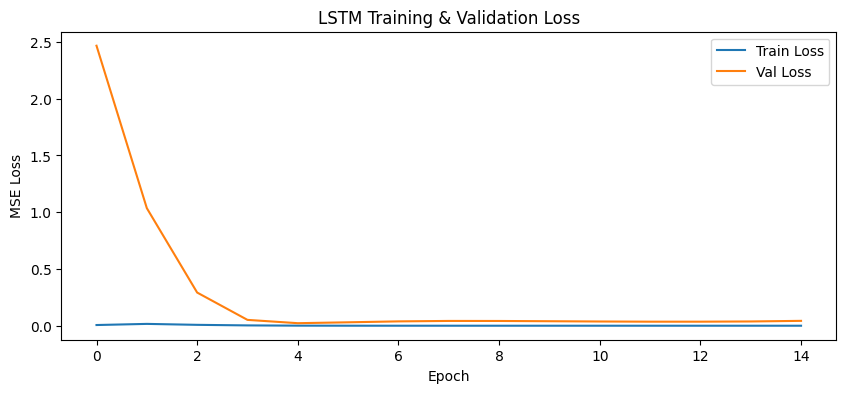

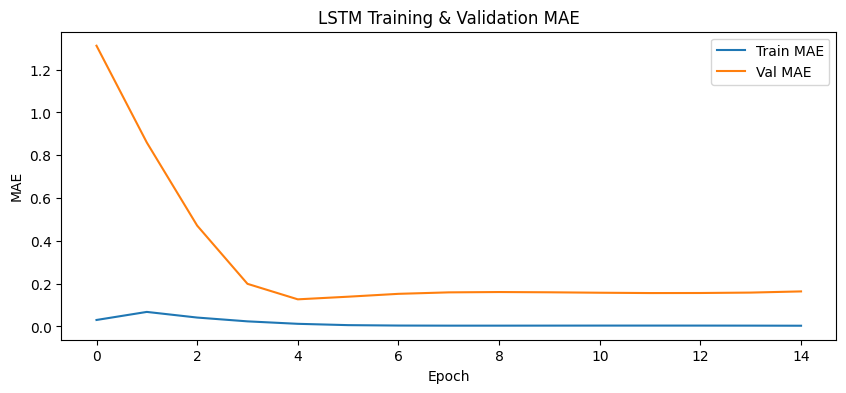

In [34]:
# 1) Inspect available keys
print("History keys:", history.history.keys())

# 2) Plot loss as before
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'],     label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# 3) Plot MAE (or whatever your metric is called)
#    Try both common key names for MAE
train_mae = history.history.get('mae') or history.history.get('mean_absolute_error')
val_mae   = history.history.get('val_mae') or history.history.get('val_mean_absolute_error')

if train_mae is not None and val_mae is not None:
    plt.figure(figsize=(10,4))
    plt.plot(train_mae, label='Train MAE')
    plt.plot(val_mae,   label='Val MAE')
    plt.title('LSTM Training & Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()
else:
    print("No MAE metric found in history; available keys:", history.history.keys())

### Computing & Displaying Test Metrics
- **What it does**
  - Calculates two standard regression error metrics on your hold-out test set:
    - **Mean Squared Error (MSE)**: <br>
    <div style="text-align: center;">$MSE = \frac{1}{N} \sum_{i=1}^N (N_{true,i} - y_{pred,i})^2$</div>
    - **Mean Absolute Error (MAE)**: <br>
    <div style="text-align: center;">$MAE = \frac{1}{N} \sum_{i=1}^N \lvert y_{true,i} - y_{pred,i}\rvert$</div>
 
- **Why RMSE and MAE?**
  - **RMSE** (Root MSE) brings the error back to the original units (USD) and penalizes larger mistakes more heavily.
  - **MAE** measures the average magnitude of errors, giving a more robust sense of typical deviation.
- **How it works**

  1. ```mean_squared_error``` and ```mean_absolute_error``` take the true (```y_test```) and predicted (```y_pred```) arrays and return scalar scores.
  2. We then compute ```RMSE = sqrt(MSE)``` using NumPy.
  3. Finally, the formatted ```print``` statement outputs both metrics rounded to two decimal places, e.g.:<br>
          ```Test RMSE: 3.47, MAE: 2.85```
  

In [35]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test RMSE: {np.sqrt(mse):.2f}, MAE: {mae:.2f}")


Test RMSE: 4.98, MAE: 4.22


### Plotting Actual vs. Predicted with Date Formatting, Split Marker & Metrics
- **Steps 1–2**: We use the final split from ```TimeSeriesSplit``` to get the indices of the test set and convert them back into actual calendar dates.
- **Step 3**: Plot the true closing prices (```y_test```) and the model’s forecasts (```y_pred```) on the same axes to compare performance over time.
- **Step 4**: Improve readability by placing a tick every three months and rotating the labels.
- **Steps 6**: Draw a vertical dashed line at the date where the test period begins and label it “Test start” so viewers know exactly which portion is out-of-sample.
- **Step 7**: Calculate standard regression metrics (RMSE and MAE) on the test set and display them directly inside the chart for quick reference.

This single, annotated plot visualizes model accuracy, the temporal split, and quantitative error measures in one comprehensive view.

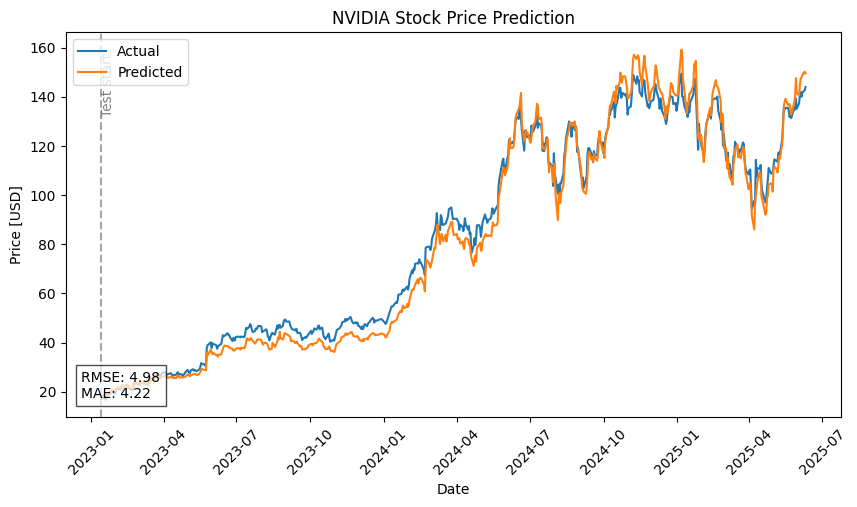

In [36]:
# 1) Retrieve the last train/test split indices
ts      = TimeSeriesSplit(n_splits=10)
splits  = list(ts.split(features_normalised))
train_idx, test_idx = splits[-1]

# 2) Map test indices back to real dates
dates_test = df.index[test_idx]

# 3) Draw the actual vs. predicted lines over time
plt.figure(figsize=(10,5))
plt.plot(dates_test, y_test.flatten(), label='Actual')
plt.plot(dates_test, y_pred,           label='Predicted')

# 4) Format the x-axis with quarterly ticks and rotated labels
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# 5) Add labels, legend, and title
plt.xlabel('Date')
plt.ylabel('Price [USD]')
plt.title('NVIDIA Stock Price Prediction')
plt.legend(loc='upper left')

# 6) Mark the point where the test period begins
split_date = dates_test[0]
plt.axvline(split_date, color='gray', linestyle='--', alpha=0.7)
plt.text(split_date,
         plt.ylim()[1] * 0.95,
         'Test start',
         rotation=90,
         va='top',
         color='gray')

# 7) Compute and annotate test metrics in the plot
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
plt.text(0.02,
         0.05,
         f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.7))

plt.show()